In [1]:
!pip install ipympl
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00


In [2]:
from pylab import *
import numba as nb
from numba import cuda

In [3]:
@cuda.jit
def heat2D(u, f, dx2):
    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y
    bwx, bwy = cuda.blockDim.x, cuda.blockDim.y
    i, j = tx + bx*bwx, ty + by*bwy
    if (i < u.shape[1] - 2) and (j < u.shape[0] - 2):
        ii = i + 1
        jj = j + 1
        unn = u[ii - 1, jj]
        uww = u[ii, jj - 1]
        uee = u[ii, jj + 1]
        uss = u[ii + 1, jj]
        u[ii, jj] = 0.25*(unn + uee + uss + uww - dx2[0]*f[ii, jj])

@cuda.jit
def heat2D_9(u, f, dx2):
    ty, tx = cuda.threadIdx.x, cuda.threadIdx.y
    by, bx = cuda.blockIdx.x, cuda.blockIdx.y
    bwy, bwx = cuda.blockDim.x, cuda.blockDim.y
    i, j = tx + bx*bwx, ty + by*bwy
    ii, jj = i + 1, j + 1
    cte = 1.0/12.0
    if (ii < u.shape[1] - 1) and (jj < u.shape[0] - 1):
        unn = 2*u[ii - 1, jj]
        uee = 2*u[ii, jj + 1]
        uss = 2*u[ii + 1, jj]
        uww = 2*u[ii, jj - 1]

        une = u[ii - 1, jj + 1]
        use = u[ii + 1, jj + 1]
        usw = u[ii + 1, jj - 1]
        unw = u[ii - 1, jj - 1]

        u[ii, jj] = cte*(unn + une + uee + use + uss + usw + uww + unw - 4*dx2[0]*f[ii, jj])


@cuda.jit
def heat2D_9_shared(u, f, dx2):
    ty, tx = cuda.threadIdx.x, cuda.threadIdx.y
    by, bx = cuda.blockIdx.x, cuda.blockIdx.y
    bwy, bwx = cuda.blockDim.x, cuda.blockDim.y

    # Define shared memory
    sh_u = cuda.shared.array((10, 10), dtype=nb.float64)

    # Load data into shared memory
    i, j = tx + bx * bwx, ty + by * bwy
    ii, jj = i + 1, j + 1
    it, jt = tx + 1, ty + 1
    cte = 1.0/12.0

    sh_u[it, jt] = u[ii, jj]

    # Load ghost cells
    if (i < u.shape[0]) & (j < u.shape[1]):
        if tx == 0:
            sh_u[it - 1, jt] = u[ii - 1, jj]
        if tx == bwx - 1:
            sh_u[it + 1, jt] = u[ii + 1, jj]
        if ty == 0:
            sh_u[it, jt - 1] = u[ii, jj - 1]
        if ty == bwy - 1:
            sh_u[it, jt + 1] = u[ii, jj + 1]

        if tx == 0 and ty == 0:
          sh_u[it - 1, jt - 1] = u[ii - 1, jj - 1]
        if tx == bwx - 1 and ty == 0:
          sh_u[it + 1, jt - 1] = u[ii + 1, jj - 1]
        if tx == 0 and ty == bwy - 1:
          sh_u[it - 1, jt + 1] = u[ii - 1, jj + 1]
        if tx == bwx - 1 and ty == bwy - 1:
          sh_u[it + 1, jt + 1] = u[ii + 1, jj + 1]

    # Synchronize threads to make sure all data is loaded into shared memory
    cuda.syncthreads()

    # Compute using shared memory
    if (ii < u.shape[0] - 1) and (jj < u.shape[1] - 1):
        unn = 2 * sh_u[it - 1, jt]
        uee = 2 * sh_u[it, jt + 1]
        uss = 2 * sh_u[it + 1, jt]
        uww = 2 * sh_u[it, jt - 1]

        une = sh_u[it - 1, jt + 1]
        use = sh_u[it + 1, jt + 1]
        usw = sh_u[it + 1, jt - 1]
        unw = sh_u[it - 1, jt - 1]

        u[ii, jj] = cte * (unn + une + uee + use + uss + usw + uww + unw - 4 * dx2[0] * f[ii, jj])



@cuda.jit
def heat2D_9_shared_h(u, f, dx2):
    ty, tx = cuda.threadIdx.x, cuda.threadIdx.y
    by, bx = cuda.blockIdx.x, cuda.blockIdx.y
    bwy, bwx = cuda.blockDim.x, cuda.blockDim.y

    # Define shared memory
    sh_u = cuda.shared.array((10, 10), dtype=nb.float64)

    # Load data into shared memory
    i, j = tx + bx * bwx, ty + by * bwy
    ii, jj = i + 1, j + 1
    it, jt = tx + 1, ty + 1
    cte = 1.0/12.0

    ht = ty + bwx*tx
    it_1, jt_1 = ht // 10, ht % 10
    jj_1 = (jt_1 + by * 8)
    ii_1 = (it_1 + bx * 8)
    sh_u[it_1, jt_1] = u[ii_1, jj_1]
    ht += 64
    if ht < 100:
      it_1, jt_1 = ht // 10, ht % 10
      jj_1 = (jt_1 + by * 8)
      ii_1 = (it_1 + bx * 8)
      sh_u[it_1, jt_1] = u[ii_1, jj_1]

    # Synchronize threads to make sure all data is loaded into shared memory
    cuda.syncthreads()

    # Compute using shared memory
    if (ii < u.shape[0] - 1) and (jj < u.shape[1] - 1):
        unn = 2 * sh_u[it - 1, jt]
        uee = 2 * sh_u[it, jt + 1]
        uss = 2 * sh_u[it + 1, jt]
        uww = 2 * sh_u[it, jt - 1]

        une = sh_u[it - 1, jt + 1]
        use = sh_u[it + 1, jt + 1]
        usw = sh_u[it + 1, jt - 1]
        unw = sh_u[it - 1, jt - 1]

        u[ii, jj] = cte * (unn + une + uee + use + uss + usw + uww + unw - 4 * dx2[0] * f[ii, jj])
        # u[ii, jj] = sh_u[it, jt]

In [4]:
N = 128
u = ones((N, N))
u[0, :] = u[:, 0] = u[-1, :] = u[:, -1] = 0
f = zeros((N, N))
x = linspace(0, 1, 128)
dx = x[1] - x[0]
dx2 = dx**2
f[64, 64] = -1/dx2
u_device, f_device, dx2_device = map(lambda x: cuda.to_device(x), (u, f, [dx2,]))
for i in range(20000):
  heat2D_9_shared[(N//8, N//8), (8, 8)](u_device, f_device, dx2_device)

(<matplotlib.collections.QuadMesh at 0x7bd6d51c1fc0>,
 (0.0, 128.0, 0.0, 128.0),
 <matplotlib.colorbar.Colorbar at 0x7bd6c1d6ae90>)

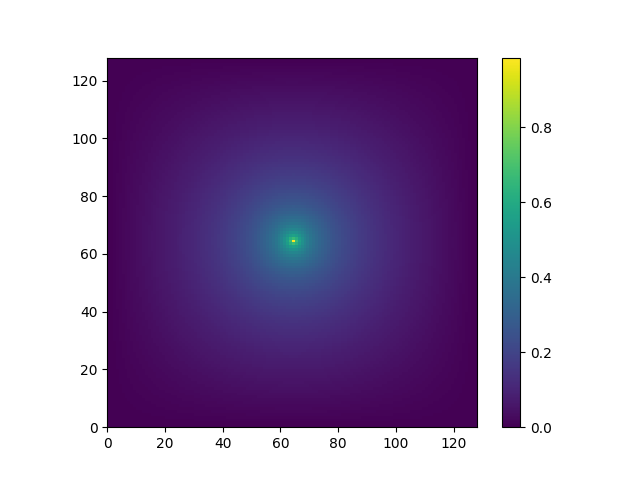

In [5]:
close("all")
pcolormesh(u_host := u_device.copy_to_host()),axis("image"), colorbar()

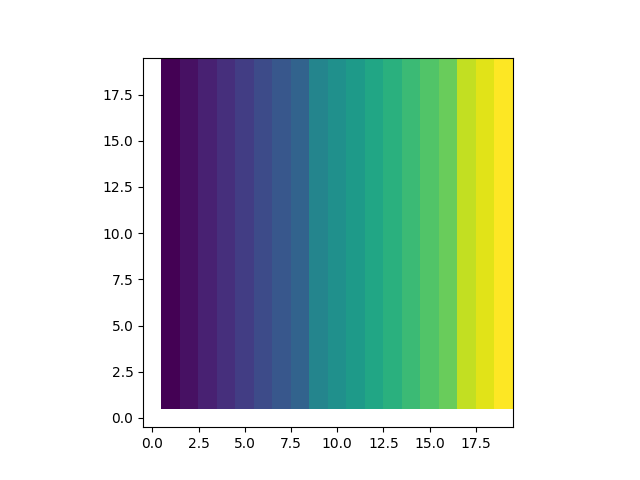

In [ ]:
close("all")
imshow(u_host[0:20, 0:20], origin="lower")

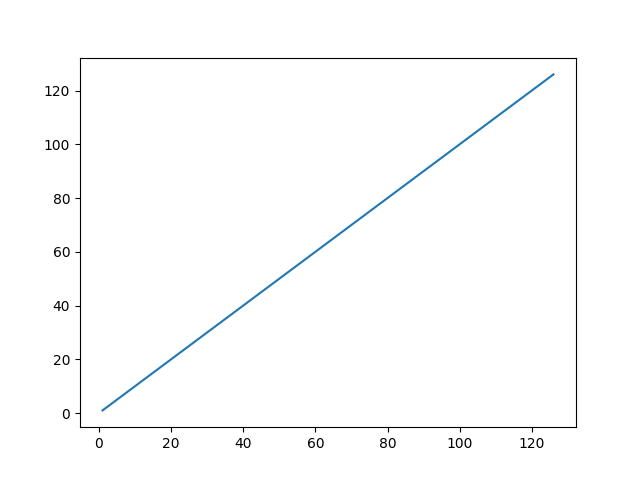

In [ ]:
close("all")
plot(u_host[:, 10])

In [ ]:
%timeit heat2D_9_shared[(N//8, N//8), (8, 8)](u_device, f_device, dx2_device)

76.8 µs ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
def solve_heat_shared():
  for i in range(20000):
    heat2D_9_shared[(N//8, N//8), (8, 8)](u_device, f_device, dx2_device)

def solve_heat_shared_h():
  for i in range(20000):
    heat2D_9_shared_h[(N//8, N//8), (8, 8)](u_device, f_device, dx2_device)

def solve_heat():
  for i in range(20000):
    heat2D_9[(N//8, N//8), (8, 8)](u_device, f_device, dx2_device)

In [ ]:
%timeit solve_heat()
%timeit solve_heat_shared()
%timeit solve_heat_shared_h()


1.24 s ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.19 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.4 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
